# Quantitative Trading Strategy # 2

## Quantamental Model Development and Quantile Trading

## Sections
1. Objectives
2. Preliminaries
3. Quantamental Model Development
4. Quantile Trading Strategies
5. Comparing with Fama-French style factors
6. Conclusion

# 1. Objectives
There are two broad objectives of this analysis: <br>
<b> (a) Quantamental Model Development : </b> This involves using quantitative analysis to a company's fundamental financial performance measures. Here we start with a large universe of companies across diverse industry sectors. We filter out the companies from automotive, financial and insurance sectors as these industries have slightly different performance measures and have seen other pricing dynamics in the recent past. We apply numerious filters to remove the companies which have missing data or where the financial ratios fail to quanitfy the underlying performance of the companies.<br>

Once such a model is built, we would try building a Quantile Trading Strategy that could be used to profit from such Quantamental model data. 

<br>
<b> (b) Quantile Trading Strategies :</b> The key metric to quantile trading is a <b> Ranking Criteria </b> that we use to execute a trading strategy. This criteria could be simple such as a financial ratio, say Price to Earnings Ratios of the companies in consideration. We rank each of the company under consideration based on its Price to Earnings Ratios. Since we would consider a low Price to Earnings Ratio as undervalued and high Price to Earnings ratio as overvalued, we would go long on companies with relatively low Price to Earnings and short on companies with relatively high Price to Earnings. We would choose only the top and bottom quantiles (say 10%) for executing such a strategy. Note that only the relative performance of the companies financial performance is considered in this strategy and not the actual absolute value of the performance. It is therefore a good idea to convert the performance metrics into a z-score metric.<br>


This analysis illustrates the criteria for filtering out at least 200 stocks trading in the United States out of the entire company database. Subsequently, this analysis tries executing Quantile Trading Strategies based on multiple fundamental factors. Here, we would limit our trading window from January 2014 to January 2021 (7 year period).


# 2. Preliminaries
Here, we define the various Python libraries used here. We also define most of the functions that shall be used later in the assignment.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as pdr
import numpy as np
import nasdaqdatalink
import seaborn as sns

sns.color_palette("mako", as_cmap=True)

import plotnine as p9
plt.rcParams["figure.figsize"] = [15,6]

import warnings
warnings.filterwarnings('ignore')

from collections import defaultdict

In [2]:
def buildStrategy(initialCapital, rankCriteria, weightStrategy, quantile, holdingWindow = None):
    
    '''
    Builds a monthly quantile trading strategy based on:    
    1. rankCriteria (generally a z-score measure),
    2. weightCriteria (equalWeighted, mCapWeighted, stratified)
    3. Quantile traded (around 10%)
    4. Holding Window (threshold to hold the stock in subsequent month)    
    '''
    
    capital = initialCapital    
    track = tracker.copy()
    n = int(round(len(fullDataSet.loc[track.loc[0,'EnterDate']])*quantile,0))
    
    if holdingWindow is None:
        h = n
    else:
        h = int(round(len(fullDataSet.loc[track.loc[0,'EnterDate']])*holdingWindow,0))
    
    long, short, longHold, shortHold = [], [], [], []
    trades, holdCount = 0, 0
    
    
    for idx in track.index:
        
        track.loc[idx,'StartCapital'] = capital
        
        enterDay = fullDataSet.loc[track.loc[idx,'EnterDate']]
        exitDay = fullDataSet.loc[track.loc[idx,'ExitDate']]
        
        #At each investment period, we invest 10% of our gross capital - 5% in long positions and 5% in short 
        track.loc[idx,'ShortPos'] = -capital/20
        track.loc[idx,'LongPos'] = capital/20
        
        #Exract Enter and Exit Dates
        start = track.loc[idx,'EnterDate']
        finish = track.loc[idx,'ExitDate']
        repo = track.loc[idx,'RepoRate']
        
        #Compute Repo Cash flow from shorting securties based on A/360 days
        track.loc[idx,'RepoCash'] = -(finish - start).days/360 * repo * track.loc[idx,'ShortPos']/100
        
        
        #get the list of securties to take short and long positions based on the given allocationfullDataSet 
        ranks = list(enterDay.sort_values(by = rankCriteria)['ticker'])
        shortHoldCandidate = ranks[:h]
        if h == 0:
            longHoldCandidate = []
        else:
            longHoldCandidate = ranks[-h:]
        
        #make a list of securties to hold by taking an intersection of previously traded companies and current candidates
        shortHold = list(set(short) & set(shortHoldCandidate))        
        longHold = list(set(long) & set(longHoldCandidate))
       
               
        short = ranks[:n-len(shortHold)] + shortHold        
        if n == len(longHold):
            long = longHold
        else:
            long = ranks[-n+len(longHold):] + longHold
            
        #Count raw trades and a reduction from holding some securties in the next trading period
        trades += 2*(len(short) + len(long))
        holdCount += 2*(len(shortHold) + len(longHold))
        
        
        #Compute allocations based on the weightStrategy using the computeWeights function
        shortAllocation = computeWeights(short,weightStrategy,enterDay)
        longAllocation = computeWeights(long,weightStrategy,enterDay)
        
        # Allocate the traded volume to the relevant industry sector for further analysis
        sectors = defaultdict(int)        
        for i,s in enumerate(short):
            sectors[enterDay[enterDay['ticker'] == s]['zacks_sector_code'][0]] += \
                                                        shortAllocation[i]*track.loc[idx,'ShortPos']            
        for i,l in enumerate(long):
            sectors[enterDay[enterDay['ticker'] == l]['zacks_sector_code'][0]] += \
                                                        longAllocation[i]*track.loc[idx,'LongPos']            
        for s in sectors:
            track.loc[idx,zacksSectors[s]] = sectors[s]
        
        
        #Compute PnL for Long and short positions individually
        shortPnL = 0
        for i,t in enumerate(short):
            shortPrice = enterDay[enterDay['ticker'] == t]['adj_close'][0]
            shortShares = track.loc[idx,'ShortPos'] * shortAllocation[i]/shortPrice
            
            exitPrice = exitDay[exitDay['ticker'] == t]['adj_close'][0]
            exitPnL = shortShares*(exitPrice - shortPrice)

            shortPnL += exitPnL            
        
        longPnL = 0
        for i,t in enumerate(long):
            longPrice = enterDay[enterDay['ticker'] == t]['adj_close'][0]
            longShares = track.loc[idx,'LongPos'] * longAllocation[i]/longPrice

            exitPrice = exitDay[exitDay['ticker'] == t]['adj_close'][0]
            exitPnL = longShares*(exitPrice - longPrice)

            longPnL += exitPnL
        
        #udate tracker
        track.loc[idx,'ShortPnL'] = shortPnL
        track.loc[idx,'LongPnL'] = longPnL    
        track.loc[idx,'MonthPnL'] = shortPnL + longPnL + track.loc[idx,'RepoCash']
        track.loc[idx,'EndCapital'] = capital + track.loc[idx,'MonthPnL']
        capital = track.loc[idx,'EndCapital']
    
    track['CumPnL'] = track['MonthPnL'].cumsum()    
    return track,trades - holdCount

In [3]:
def computeWeights(securities, weightStrategy, enterDay):
    
    '''
    Given a list of securites to be traded on a given enterDay, computes the weights for allocation of capital
    '''
    
    if weightStrategy == 'equalWeighted':
        n = len(securities)
        allocation = [1/n for _ in range(n)]
        
        return allocation
    
    elif weightStrategy == 'mCapWeighted':
        mcaps = [enterDay[enterDay['ticker'] == s]['mcap'][0] for s in securities]
        total = sum(mcaps)
        allocation = [m/total for m in mcaps] 
        
        return allocation
    
    elif weightStrategy == 'stratified':
        n = len(securities)
        rank = [i for i in range(1,n+1)]
        wts = [max(0,0.1*(1/r-0.02)) for r in rank]
        total = sum(wts)
        allocation = [i/total for i in wts]
        
        return allocation

In [4]:
def summaryStats(df):
    
    '''
    function to display the summary statistics of a given dataframe
    '''
    
    summary = pd.DataFrame(index = df.columns)    
    summary['Mean Annualized Return'] = df.mean()*12
    summary['Annualized Volatility'] = df.std()*np.sqrt(12)
    summary['Sharpe Ratio'] = summary['Mean Annualized Return']/summary['Annualized Volatility']    
    summary['Skewness'] = df.skew()
    summary['Excess Kurtosis'] = df.kurt()
    summary['Minimum return'] = df.min()
        
    return summary

In [5]:
def analyzeStrategy(initialCapital,rankCriteria,quantile, holdingWindow = None):
    
    '''
    Function used to analyze a strategy in entirity by plotting the returns under various criteria, computing returns and 
    financial statistics
    '''
    
    fig, ax = plt.subplots(1, 3, figsize=(18, 8))
    store = []
    weightStrategies = ['equalWeighted','mCapWeighted','stratified']
    
    for i,w in enumerate(weightStrategies):
    
        tr1, t1 = buildStrategy(initialCapital,rankCriteria,w,quantile)
        tr2, t2 = buildStrategy(initialCapital,rankCriteria,w,quantile, holdingWindow)
        store.append(tr1)
        
        shortProfit = tr1.ShortPnL.sum()
        longProfit = tr1.LongPnL.sum()
        repoCash = tr1.RepoCash.sum()
        
        totalProfit = shortProfit + longProfit + repoCash
        
        roc1 = round(tr1.CumPnL.iloc[-1]/tr1.StartCapital.iloc[0]*100,2)
        roc2 = round(tr2.CumPnL.iloc[-1]/tr2.StartCapital.iloc[0]*100,2)
        ax[i].plot(tr1['ExitDate'],tr1['CumPnL'],label = 'without hold')
        ax[i].plot(tr2['ExitDate'],tr2['CumPnL'],label = 'with hold')
        ax[i].legend()
        ax[i].set(title = w + f' Strategy \n \
            Without Hold: Trades = {t1}, ROC = {roc1}% \n With Hold: Trades = {t2}, ROC = {roc2}% \n\
                 Profit Share: Short: {round(100*shortProfit/totalProfit)}%, Long: {round(100*longProfit/totalProfit)}%,\
Repo: {round(100*repoCash/totalProfit)}%')
        
        
        plt.suptitle('Cummulative Profit and Loss on '+rankCriteria+' Criteria',fontsize=24)
    plt.tight_layout()
    plt.show()
    
    tr = store[0]
    ax = sns.boxplot(data=tr.iloc[:,12:])
    ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
    ax.set_title("Sectoral Distribution - Equally weighted trading strategy", fontsize = 16)
    ax.set_xlabel('Sector',fontsize = 14)
    ax.set_ylabel('Net Invested position',fontsize = 14)
    plt.show()
    
    df = pd.DataFrame()
    for s in store:
        
        df = df.append(s.MonthPnL)    
    
    results = summaryStats(df.T)
    results.index = weightStrategies
    results.index.name = 'Strategy'
    
    display(results)
    
    return store
    

In [6]:
def holdIllustration():
    
    '''
    Draws an illustration for Quantile Trading sstrategy with holds
    '''
    
    plt.figure(figsize=(8,6))
    plt.axhline(y= 0.9, color='g', linestyle='-',label = 'Buy Threshold')
    plt.axhline(y= 0.75, color='b', linestyle='dashdot',label = 'Hold Buy Threshold')
    plt.axhline(y= 0.1, color='r', linestyle='-',label = 'Sell Threshold')
    plt.axhline(y= 0.25, color='m', linestyle='dashdot',label = 'Hold Sell Threshold')
    
    plt.xticks([], [])
    plt.ylabel('Quantile',fontsize = 16)
    plt.title('Hold Strategy Illustration',fontsize = 20)

    plt.text(0.37, 0.02, 'Sell Zone', fontsize = 16)
    plt.text(0.37, 0.18, 'Hold-Sell Zone', fontsize = 16)
    plt.text(0.37, 0.82, 'Hold-Buy Zone', fontsize = 16)
    plt.text(0.37, 0.92, 'Buy Zone', fontsize = 16)

    plt.legend()
    plt.show()

## 3. Quantamental Model Development

### a. Importing Data from ZACKS
We shall be using the [ZACKS Fundamental Collection](https://www.quandl.com/databases/ZFB/documentation) data for the Quantamental Model development. ZACKS database has financial performance information relating to about 10,000 listed US stocks that could be used to build the ranking mechanism of our choice.

Here, we have tried to pickle the databases to the local machine address to avoid very large data downloads on each run.

In [7]:
nasdaqdatalink.ApiConfig.api_key = 'YourAPIkey'

In [8]:
'''Fundamentals Condensed (ZACKS/FC):
Entire dataset contains 200 fundamental indicators for over 19,500 companies'''
try:
    fc = pd.read_pickle('fc.pkl')
except:    
    print('Downloading from NasdaqDataLink')
    fc = nasdaqdatalink.get_table('ZACKS/FC', 
                          qopts = { 'columns': ['ticker', 'per_end_date','per_type','zacks_sector_code','exchange',\
                                'basic_net_eps','diluted_net_eps','tot_lterm_debt','net_lterm_debt','filing_date']},
                          per_end_date = {'gte': '2013-06-30', 'lte': '2021-01-31'}, paginate=True)       
    fc.to_pickle('fc.pkl')

In [9]:
'''
Shares Out Supplement (ZACKS/SHRS)
supplementary information to Zacks fundamentals, 
with updated values for common shares outstanding and average diluted shares outstanding
'''
try:
    shrs = pd.read_pickle("shrs.pkl")
except:
    print('Downloading from NasdaqDataLink')
    shrs = nasdaqdatalink.get_table('ZACKS/SHRS', per_end_date={'gte': '2013-06-30', 'lte': '2021-01-31'},\
            qopts={'columns':['ticker','per_end_date','per_type','shares_out']},\
            paginate = True)
    shrs.to_pickle('shrs.pkl')

In [10]:
'''
Fundamentals Ratios (ZACKS/FR)
contains 26 fundamental ratios 
'''

try:
    fr = pd.read_pickle('fr.pkl')
except:
    print('Downloading from NasdaqDataLink')
    fr = nasdaqdatalink.get_table('ZACKS/FR', per_end_date={'gte': '2013-06-30', 'lte': '2021-01-31'},\
                    qopts={'columns':['ticker', 'per_type','per_end_date',\
                                      'tot_debt_tot_equity', 'ret_invst']}, paginate = True)
    fr.to_pickle('fr.pkl')    

In [11]:
'''
Master Table (ZACKS/MT)
descriptive information about all tickers that are included in Zacks products
'''

try:
    mt = pd.read_pickle('mt.pkl')
except:
    print('Downloading from NasdaqDataLink')
    mt = nasdaqdatalink.get_table('ZACKS/MT', qopts = {'columns':['ticker','ticker_type','asset_type']},paginate=True)
    mt.to_pickle('mt.pkl')

In [12]:
'''
Market Value Supplement (ZACKS/MKTV)
supplementary information to Zacks fundamentals, with updated values for market capitalization and enterprise value.
'''

try:  
    mktv = pd.read_pickle('mktv.pkl')    
except:
    print('Downloading from NasdaqDataLink')
    mktv = nasdaqdatalink.get_table('ZACKS/MKTV', per_end_date={'gte': '2013-06-30', 'lte': '2021-01-31'},\
            qopts={'columns':['ticker', 'per_type','per_end_date','mkt_val']}, paginate = True)    
    mktv.to_pickle('mktv.pkl')   

In [13]:
#A dictionary of Zacks Sector codes
zacksSectors = {1:'Consumer Staples', 2: 'Consumer Discretionary', 3:'Retail/Wholesale', 4: 'Medical',\
               6:'Basic Materials',7:'Industrial Products',8:'Construction',\
               9:'Multi-Sector Conglomerates',10:'Business Services (Computer/Retail/Wholesale)',11:'Aerospace',\
               12: 'Oils/Energy', 14:'Utilities', 15:'Transportation', 16:'Business Services, Construction',\
                17: 'Consumer Discretionary'}

### b. ZACKS Data Processing

We begin by combining the data obtained from ZACKS databases in to one single dataframe with all the relevant information. We do this by doing subsequent inner merges on ticker, per_end_date and per_type.

In [14]:
combined = fc.merge(shrs,how='inner',left_on=['ticker','per_end_date','per_type'],\
                    right_on=['ticker','per_end_date','per_type'])

combined = combined.merge(fr,how='inner',left_on=['ticker','per_end_date','per_type'],\
                          right_on=['ticker','per_end_date','per_type'])

combined = combined.merge(mktv,how='inner',left_on=['ticker','per_end_date','per_type'],\
                          right_on=['ticker','per_end_date','per_type'])

combined = combined.merge(mt,how='inner',left_on=['ticker'], right_on=['ticker'])

print('Unique Tickers =',combined['ticker'].nunique())

Unique Tickers = 7207


Intially, we start with 7200+ tickers in out entire dataset universe. From this, we look to filter out the tickers belonging to  automotive, financial and insurance sector. From the ZACKS database, we delete the zacks_sector_code of 5 and 13. Also, as we are only looking for common stocks only, so we filter the tickers with asset_type other than  COM (Common Stock Equities)  

In [15]:
combined = combined[(combined['zacks_sector_code'] != 5) & (combined['zacks_sector_code'] != 13)]
combined = combined[combined['asset_type'] == 'COM']
print('Unique Tickers =',combined['ticker'].nunique())

Unique Tickers = 3450


This leaves us with 3450 stock tickers to consider. Next, as we are looking for companies with sufficient Debt to Equity ratios, we filter out the tickers where the average debt to equiy ratios are below 0.2

In [16]:
tickers = list(combined['ticker'].unique())
for t in tickers:
    avg_d_to_eq = combined[combined['ticker'] == t]['tot_debt_tot_equity'].mean()
    if  avg_d_to_eq < 0.2:
        combined = combined[combined['ticker'] != t]
print('Unique Tickers =',combined['ticker'].nunique())

Unique Tickers = 2359


<b>Missing data </b> is major cause of concern in a trading fullDataSet as without updated historic data, our financial ratios would not be updated for the pricing information already available in the market. Thus with 2359 tickers remaining, we filter out the tickers that have any missing data. We check for any Not Availables (NAs) in the data. We also ensure that the number of period_end_dates reported is for 23 quarters and 8 years for a total of 31 time periods . 

In [17]:
for t in tickers:    
    if (len(combined[combined['ticker'] == t]) != len(combined[combined['ticker'] == t].dropna()) or \
       len(combined[combined['ticker'] == t]) != 31):
        combined = combined[combined['ticker'] != t]

print('Unique Tickers =',combined['ticker'].nunique())

Unique Tickers = 410


We observe that from a total of 2300+ tickers of interest, only about 400 have all the required dataset for all the required time periods. Ofcourse as a fall back to this, we could have used approximations such as:
1. Using Annual data where Quarterly Data is not available
2. Using Total Long Term Debt if Net Long Term Debt not available
3. Using Basic EPS instead of Diluted EPS

We should be careful in applying such approximations as they can alter the representative data significantly thereby affecting our rankings.

### c. Merging with daily price data from Quotemedia Prices
Next, for each of the 400+ tickers, we download the daily price data from June 2013 to January 2021. Note that our trading strategy begins from January 2014 but we import data from before the trading start period to forward fill-in any financial performance indicators as required.

In [16]:
try:
    dailyPrice = pd.read_pickle('dailyPrice.pkl')
    
except:
    print('Downloading from NasdaqDataLink')    
    tickers = list(combined['ticker'].unique())    
    dailyPrice = nasdaqdatalink.get_table('QUOTEMEDIA/PRICES', ticker = list(tickers), \
                                    qopts={"columns":["ticker","date","adj_close"]}, \
                                    date = { 'gte': '2013-06-01', 'lte': '2021-01-31'}, paginate = True).iloc[::-1]
    
    for t in tickers:
        if sum(dailyPrice['ticker'] == t) != 1930:
            dailyPrice = dailyPrice[dailyPrice['ticker'] != t]
    
    dailyPrice.to_pickle('dailyPrice.pkl')
    tickers = list(dailyPrice['ticker'].unique())
    print('Unique Tickers =',combined['ticker'].nunique())

Once we have all the required fundamental performance data as well as the daily price data, we try creating a table called 'fullDataSet' that would contain all the required information. This table is constructed by successively merging the imported datasets on tickers.

In [17]:
dailyPrice.head()

,ticker,date,adj_close
None,,,
769378,AAWW,2013-06-03,46.20
769377,AAWW,2013-06-04,45.85
769376,AAWW,2013-06-05,45.31
769375,AAWW,2013-06-06,45.55
769374,AAWW,2013-06-07,46.50


In [19]:
fullDataSet = dailyPrice.merge(combined,how='left',left_on=['ticker','date'],\
                            right_on=['ticker','filing_date']).fillna(method="ffill").dropna()


fullDataSet = fullDataSet.merge(fullDataSet[['date','ticker','adj_close']],how='left',left_on=['per_end_date','ticker'],\
              right_on=['date','ticker'])

fullDataSet = fullDataSet.rename(columns={'date_x':'date','adj_close_x':'adj_close','adj_close_y':'per_end_date_adj_close'})
fullDataSet = fullDataSet.drop(columns=['date_y'])


### d. Financial Ratios

We now have the following data for each of our 400+ stock Tickers for each trading day in 2014 to 2021 in our dataset:
1. Daily Adjusted Closing Price 
3. Zacks Sector Code
4. Basic and Diluted Net EPS
5. Total and Net Long Term Debt
6. Relevant quarter period end date along with Closing Price price on that date
7. Debt to Equity, Return on Investment, Market Value


Based on these data points, we compute three fundamental factors that would change daily with the changes in the stock price:

a. <b> Debt to Market Cap </b> = $Total\ Debt\ to\ Total\ Equity\ (period\ end\ date) * \frac{\text{period End date close price}}{\text{day's close price}}$ 
<br><br>

b. <b> Price to Earnings </b> = $\frac{\text{today's close price}}{\text{available period end date diluted net EPS}}$
<br><br>
wherever price-to-earnings ratio is negative, we replace them by a ratio of 0.001


c. <b> Return on Investment </b> = $Return\ on\ Invst\ (period\ end\ date) * \frac{\text{Net Long Term Debt + Market Value}}{\text{Net Long Term Debt + Market Value} \frac{\text{adj close price}}{\text{period end close price}}}$ 


In [20]:
mCapChangeMultiplier = fullDataSet['per_end_date_adj_close']/fullDataSet['adj_close']

fullDataSet['mcap'] = fullDataSet['shares_out'] * fullDataSet['adj_close']

fullDataSet['debt_to_mcap'] = fullDataSet['tot_debt_tot_equity']*mCapChangeMultiplier

fullDataSet['ret_on_invst'] = fullDataSet['ret_invst'] * \
            ((fullDataSet['net_lterm_debt'] + fullDataSet['mkt_val']) \
             /(fullDataSet['net_lterm_debt'] +  fullDataSet['mkt_val']/mCapChangeMultiplier))

fullDataSet['price_to_earnings'] = fullDataSet['adj_close'] / fullDataSet['diluted_net_eps']

fullDataSet['price_to_earnings'] = np.where(fullDataSet['price_to_earnings'] < 0, 0.001, fullDataSet['price_to_earnings'])

Once we have computed the ratios, we group and aggregate to see the distribution of our financial ratios. <u>This grouping has to be done at an individual Ticker level.

In [21]:
dataStats = fullDataSet.groupby('ticker').agg({'debt_to_mcap':['mean','std','min','max'], \
                                'ret_on_invst':['mean','std','min','max'],
                               'price_to_earnings':['mean','std','min','max']})
dataStats.describe()

debt_to_mcap                                        ret_on_invst  \
              mean          std         min          max          mean   
count   386.000000   386.000000  386.000000   386.000000    386.000000   
mean      3.329764    10.078889   -7.817097    56.120132    143.449445   
std      15.656151    67.658692   53.889052   387.760812   2796.556519   
min      -9.221773     0.061907 -891.325015     0.408178    -65.800292   
25%       0.622814     0.295868    0.078174     2.010482      0.420258   
50%       0.954516     0.477095    0.266809     3.195397      1.343359   
75%       1.626842     1.196301    0.528902     7.184637      2.154374   
max     242.221615  1079.832740    2.084295  5748.908397  54944.568403   

                                                 price_to_earnings  \
                 std           min           max              mean   
count     386.000000  3.860000e+02  3.860000e+02        386.000000   
mean     1905.420746 -4.681074e+04  4.339448e+04               inf   
std     37101.627150  9.165029e+05  8.469260e+05               NaN   
min         0.212604 -1.800654e+07  1.658335e-02          2.562328   
25%         1.190062 -1.124982e+01  4.092658e+00         61.658637   
50%         2.032598 -3.732393e+00  5.935972e+00         87.473924   
75%         3.625626 -3.967875e-01  1.057478e+01        144.773399   
max    728941.154280  3.864329e+00  1.663943e+07               inf   

                                             
               std         min          max  
count   338.000000  386.000000   386.000000  
mean    147.824889    2.781487          inf  
std     249.767185    9.828839          NaN  
min       6.602692    0.001000    27.571019  
25%      35.298062    0.001000   211.952312  
50%      67.508974    0.001000   473.322810  
75%     146.817325    0.001000  1491.787568  
max    2574.965230   81.846552          inf

<b> Observation: </b> We note that while most of the ratios have stable values, some of the ratios have extremely large min and max values. In order to further clean up our data, we remove the tickers that have any of the financial ratios that are extremely large. Below, we have defined the limits on the tolerance for each of our ratio. This tolerance is quite wide as we are applying it to a very large dataset of 400+ tickers over 7 year period. The tolerance could be adjusted to filter out in the desired manner.

In [22]:
debt_to_equity_mean = 0.1
debt_to_equity_max = 50

ret_on_invst_min = -50
ret_on_invst_max = 200

price_to_earn_min = 0
price_to_earn_max = 1000

for t in dataStats.index:
    flag = False
    if (dataStats.loc[t,'debt_to_mcap']['mean'] < debt_to_equity_mean) or \
            (dataStats.loc[t,'debt_to_mcap']['max'] > debt_to_equity_max):
        flag = True
    if (dataStats.loc[t,'ret_on_invst']['min'] < ret_on_invst_min) or \
            (dataStats.loc[t,'ret_on_invst']['max'] > ret_on_invst_max):
        flag = True
    if (dataStats.loc[t,'price_to_earnings']['min'] < price_to_earn_min) or \
            (dataStats.loc[t,'price_to_earnings']['max'] > price_to_earn_max):
        flag = True
        
    if flag:
        fullDataSet = fullDataSet[fullDataSet['ticker'] != t]

print('Unique Tickers =',fullDataSet['ticker'].nunique())

Unique Tickers = 229


After filtering out extreme ratios, we are left with about 230 tickers. The rest of our strategy would use these tickers for trading.

Further, we define a <u> new ratio </u> of <b> Debt to Earning </b> computed as the product of Debt ot Market Cap and Price to Earnings ratios.

In [23]:
fullDataSet['debt_to_earnings'] = fullDataSet['debt_to_mcap'] * fullDataSet['price_to_earnings']

Also, we would try analyzing trading strategies not just on raw ratios but also on the change observed in raw indicators. <b> Thus we compute the daily change in each of our four factors

In [24]:
fullDataSet['change_debt_to_mcap'] = fullDataSet['debt_to_mcap']/fullDataSet['debt_to_mcap'].shift() - 1
fullDataSet['change_ret_on_invst'] = fullDataSet['ret_on_invst']/fullDataSet['ret_on_invst'].shift() - 1
fullDataSet['change_price_to_earnings'] = fullDataSet['price_to_earnings']/fullDataSet['price_to_earnings'].shift() - 1
fullDataSet['change_debt_to_earnings'] = fullDataSet['debt_to_earnings']/fullDataSet['debt_to_earnings'].shift() - 1

### e. Computing the z-scores
Since the ratios for each of the ticker would be quite different from the ratios of other tickers, we cannot simply compare them one to one while executing our trading strategies. Thus we would normalize the each ticker's ratios over the 7 year trading window so as to get a comparable z-score. <b> We do this for each of our four ratios and for each of the four corresponding change in ratio.

In [25]:
ticker_normalization = list()
for _,group in fullDataSet.groupby('ticker'):
    group['z_debt_to_mcap'] = (group['debt_to_mcap'] - group['debt_to_mcap'].mean())/group['debt_to_mcap'].std()
    
    #Put negative sign on ratios that we want to be large for going long (small for going short)
    group['z_ret_on_invst'] = -(group['ret_on_invst'] - group['ret_on_invst'].mean())/group['ret_on_invst'].std()
    
    
    group['z_price_to_earnings'] = (group['price_to_earnings'] - group['price_to_earnings'].mean()) \
                                    /group['price_to_earnings'].std()
        
    group['z_debt_to_earnings'] = (group['debt_to_earnings'] - group['debt_to_earnings'].mean()) \
                                    /group['debt_to_earnings'].std()    
    
    
    group['z_change_debt_to_mcap'] = (group['change_debt_to_mcap'] - group['change_debt_to_mcap'].mean())\
                                    /group['change_debt_to_mcap'].std()
    group['z_change_ret_on_invst'] = (group['change_ret_on_invst'] - group['change_ret_on_invst'].mean())\
                                    /group['change_ret_on_invst'].std()
    group['z_change_price_to_earnings'] = (group['change_price_to_earnings'] - group['change_price_to_earnings'].mean())\
                                    /group['change_price_to_earnings'].std()
    group['z_change_debt_to_earnings'] = (group['change_debt_to_earnings'] - group['change_debt_to_earnings'].mean())\
                                    /group['change_debt_to_earnings'].std()
        
    ticker_normalization.append(group)
fullDataSet = pd.concat(ticker_normalization)

In [26]:
fullDataSet = fullDataSet[fullDataSet['date'] > '2014']
fullDataSet = fullDataSet.set_index(['date'])

Finally, we define a <b> combination factor of z-scores </b> based on giving some weightages to othe z-scores. Here we have given equal weights to each of the z-score for Debt-to-Mcap, Return on Investment and Price to Earnings. The weights can be modified based on preferance.

In [27]:
wts = (-1,1,-1) #equal weights
fullDataSet['z_score_combo'] = wts[0]*fullDataSet['z_debt_to_mcap'] + wts[1]*fullDataSet['z_ret_on_invst'] \
                        + wts[2]*fullDataSet['z_price_to_earnings']

### f. Other required data

As we are shorting some securites here, we are expected to receive the Repo Rate on these short positions. In this analysis, we would assume a Repo Rate of LIBOR/SOFR - 100 bps for the given Repo period. We compute the relevant LIBOR.SOFR Rate as the sum of 3M Treasury Rate and Ted Spread.

In [28]:
TedRate = nasdaqdatalink.get("FRED/TEDRATE")
TBill3M = nasdaqdatalink.get("FRED/DTB3")
repoRate = (TedRate + TBill3M).fillna(method="ffill").dropna() - 1.00

We also keep a dataframe that would track the performance of our strategies

In [29]:
startDates = []
repoRates = []
for y in range(2014,2021):
    for m in range(1,13):
        period = str(y) + '-' + str(m)
        startDates.append(fullDataSet.loc[period].index[0])
        repoRates.append(repoRate.loc[startDates[-1]][0])
        
        
startDates.append(fullDataSet.loc['2021-01'].index[0])
repoRates.append(repoRate.loc[startDates[-1]][0])
tracker = pd.DataFrame(columns = ['EnterDate','ExitDate','StartCapital','ShortPos','LongPos','ShortPnL','LongPnL',\
                                  'RepoRate','RepoCash','MonthPnL','CumPnL','EndCapital'])
tracker['RepoRate'] = repoRates
tracker['EnterDate'] = startDates
tracker['ExitDate'] = tracker['EnterDate'].shift(-1)
tracker.loc[84,'ExitDate'] = fullDataSet.loc['2021'].index[-1]
for z in zacksSectors.values():
    tracker[z] = 0
pd.options.display.float_format = '{:,.2f}'.format

## Strategy
Now we have multiple z-score parameters for each of the ticker with daily datapoints. We would use these z-scores to rank our tickers and execute quantile trading. Some of the assumptions we use in this analysis are:
1. Total Initial Capital is USD 1 Million
2. In each trading period (here monthly), we take equal long and short positions with gross cash as 10% of our period starting capital. Thus we invest 5% of our capital in long positions and go short for another 5% of our capital equivalent.
3. We earn a Repo rate of LIBOR/SOFR - 100 bps computed A/360 for the trading period on the net cash value of short position
4. We do not consider any trading or associated costs
5. The returns are computed over the entire 7 year trading period

We can study our strategy on various factors such as:
- The z-score used for ranking the securites (already constructed 9 z-scores)
- The weight allocation 
- The quantile and holding window sizes


### a. Weight Allocation Strategies
We try three different strategies for the weights of individual stocks.:

1. <b> equalWeighted :</b> This is $1/N$ strategy in which we give equal weightage to each of the stock we go long and short
2. <b> mCapWeighted :</b> Here, among the stocks selected for going Long and Short, we give the weights based on the market capitalization of each of the security selected. Hence, we neglect the relative ranking among the long and shorts  while giving the weights.
3. <b> stratified : </b> Stratified weighing gives weights based on the rank of each security within the Long or Short bucket. For instance, among the securites we want to go short, we shall give maximum weight to the security that has the best rank for going short. There are many ways to implement this weighing mechanism. Here we use a formula: <br><br> $weight_i = max(0,\frac{1}{rank_i} - 0.02)$ <br><br>The weights are normalized to add up to one. This formula allows to give large weights to top ranked securities and the difference tapers down as we go lower down the ranks.

### b. The quantile and holding window sizes
In a trading strategy based on ranking, it is likely that the portfolio of stocks that we trade completely changes in each of the trading period. In such a scenario, we would be paying substantial transaction costs to sell the long positions and establish new short positions. One way around this is to define a buffer zone close to both Buy and Sell quantiles. We would not trade a security that goes from Buy Zone to Hold Buy Zone and similarly a security that goes from Sell Zone to Hold Sell Zone.

These zones are illustrated below:

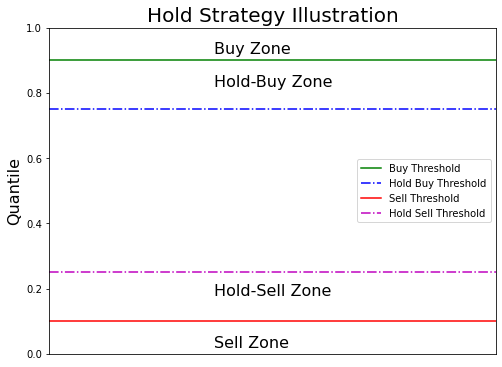

In [30]:
holdIllustration()

### c. Ranking based on the z-score
Based on the z-scores we created in the previous section along with the Weight Strategies defined above, we compare the Returns on Capital for each of our security. This is a base line analysis assuming equal weightage for each buy and sell security in each period of a trading strategy. We also do not assume any additional hold window here. All strategies are executed at 10% Quantile for Buy and 10% Quantile for Sell.

In [31]:
strategyEvaluation = pd.DataFrame(columns = ['Return on Capital (%)'])
strategyEvaluation.index.name = 'Ranking Criteria'
for r in fullDataSet.columns[-9:]:
    tr, t = buildStrategy(1e6,r,'equalWeighted',0.1)
    roc = round(tr.CumPnL.iloc[-1]/tr.StartCapital.iloc[0]*100,2)
    strategyEvaluation.loc[r,'Return on Capital (%)'] = roc
strategyEvaluation.sort_values(by = 'Return on Capital (%)',ascending=False)

,Return on Capital (%)
Ranking Criteria,
z_debt_to_mcap,6.27
z_ret_on_invst,5.55
z_score_combo,4.01
z_change_ret_on_invst,1.19
z_change_debt_to_mcap,0.79
z_change_debt_to_earnings,0.40
z_change_price_to_earnings,-0.78
z_debt_to_earnings,-3.08
z_price_to_earnings,-5.84


<b> Observations </b> We note that some of the strategies performed poorly over the 7 year period giving negative returns. Even the best performing strategy gave an unannualized return of only about 6.3%.<br>

- Among the strategies, Debt to Market Cap ranking dominates. This indicates that relatively low leverage companies outperformed high leverage companies. <b> This could also be because of the boom in new age companies such as tech stocks that have low leverage relative to traditional manufacturing companies that typically have higher debts. </b> 
- We also observe good returns based on return on investment scores which indicates that companies that could deploy capital well continued to give good returns. This is also in line with expectations and general bull markets in the time frame.
- We have <b> poor returns based on Price to Earnings multiples. This may be again because new age tech companies that have relatively high Price valuations continued to shine with even higher price multiples. Thus a trading strateg on such metric was bound to give bad returns. </b> 


Next, we try to analyze the individual performance of some of the best and worst performing strategies and try attributing the performance and see how changing the weighting and holding window could affect the returns

### d. Strategy I : Best Performing Strategy: z_debt_to_mcap
For the best performing strategy based on the z-score of Debt to Market Cap, we now try the different weight and hold strategies.

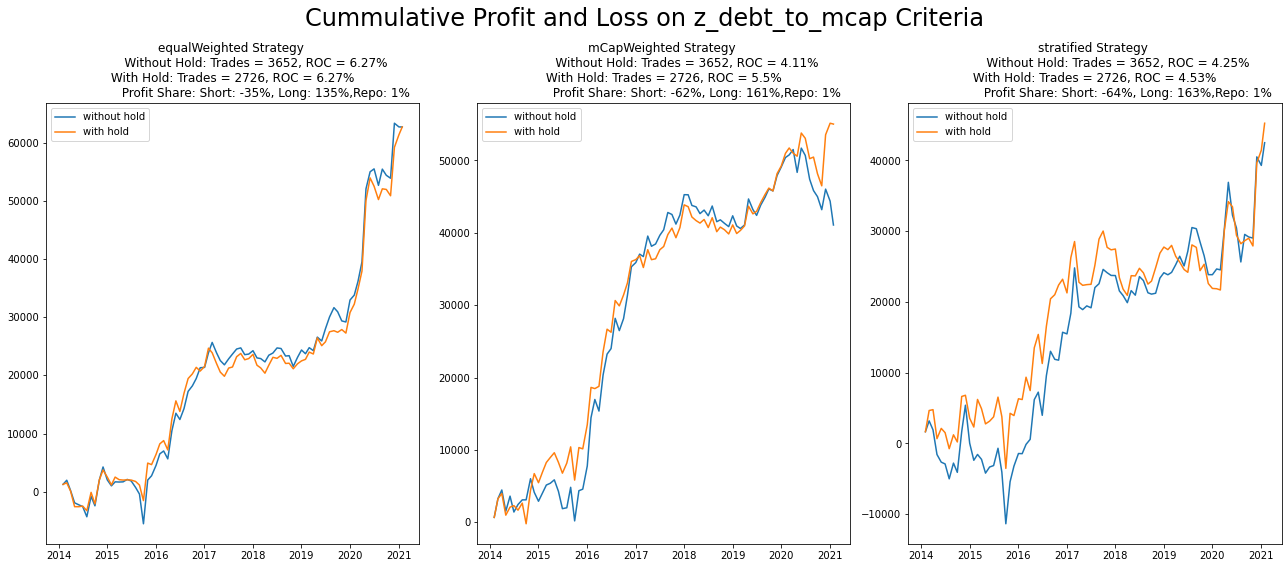

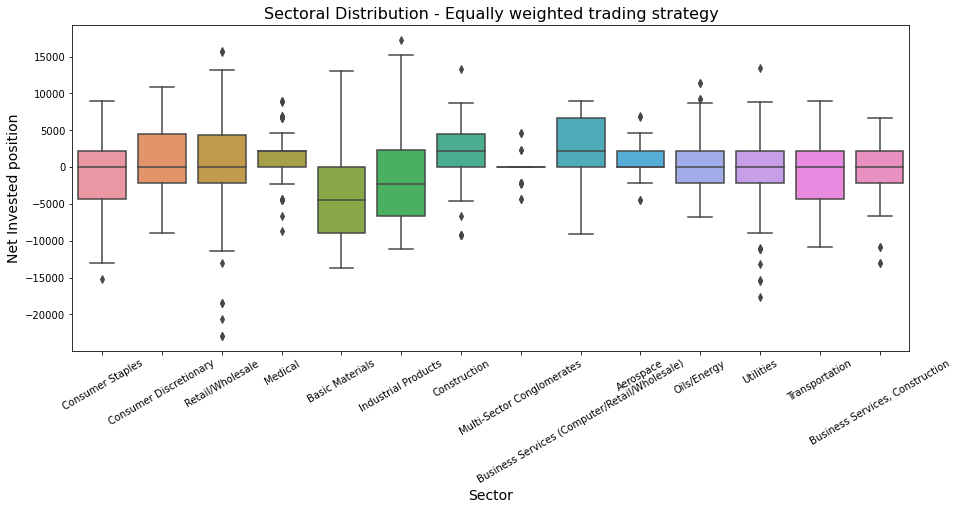

,Mean Annualized Return,Annualized Volatility,Sharpe Ratio,Skewness,Excess Kurtosis,Minimum return
Strategy,,,,,,
equalWeighted,"8,849.00","8,604.71",1.03,1.90,6.90,"-5,099.37"
mCapWeighted,"5,799.73","7,197.33",0.81,0.23,0.16,"-4,643.25"
stratified,"6,002.29","10,383.77",0.58,0.53,1.72,"-7,307.50"


In [32]:
strategy1 = analyzeStrategy(initialCapital = 1000000,rankCriteria = 'z_debt_to_mcap',quantile = 0.1,holdingWindow = 0.2)

<b> Observations: Debt to Market Ratio z-score strategy</b> <br>
<u> Cummulative Profit and Loss </u>
1. The equal-weighted strategy outperforms both MarketCap weighted and stratified weighted strategies.
2. <b> In each of the strategy, the short positions loses money over the time horizon. </b> This may be because the equity markets had a bull run over the last decade and thus most stocks performed well in the period. Thus long only strategy would have performed better than the long-short strategies considered here.
3. All strategies had high year to year variability in performance. The strategies did not show much profitability until 2016 and then started showing decent returns
4. The strategies that implement a hold on the stocks in a trading window performed equally or better than the stratagies without such hold conditions. <b>This has important implications because as of now, we are not considering any trading costs. After including trading costs, the strategies requiring a hold thresholds would be much cheaper to implement and thus the returns would be much higher than the frequent trading strategy without hold thresholds.</b>
<br>
<br>
<u> Sector weights </u>
1. The straty distributes weights across most of the industry sectors over time.
2. The portfolio goes short on traditional sectors such as Materials and Transportation and long on Retail/Wholesale and multi-sector conglomerates<br>
<br>
<u> Performance Summary Statistics </u>
1. The returns are extremely volatile. This is because the series is constructed using month on month performances and returns in each month typically vary quite a lot
2. Owing to the large volatility figures, the sharpe ratios are not as good

#### Changing the trading and holding quantiles

Next, we modify the trading and holding quantiles to 20% and 30% respectively. Thus, we buy the top 20%, will not sell these securities until they are in top 30%. Similarly, we short the bottom 20% and will not close the shorts until the security is in the bottom 30%. 

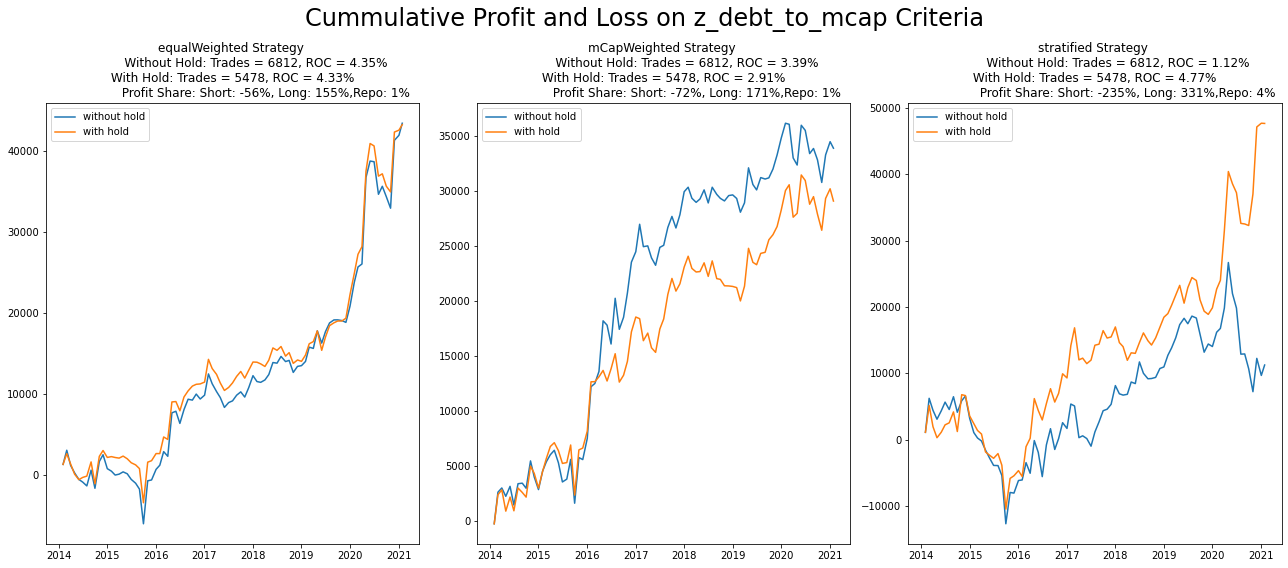

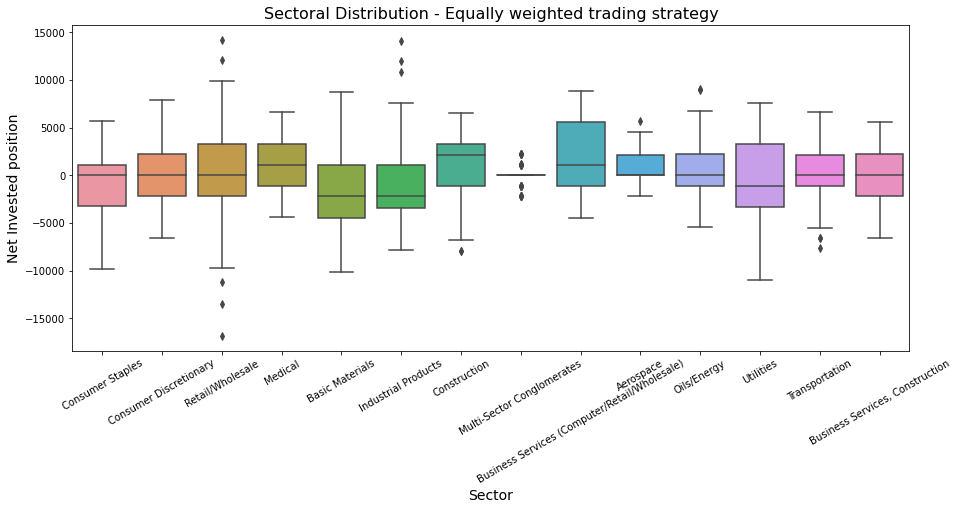

,Mean Annualized Return,Annualized Volatility,Sharpe Ratio,Skewness,Excess Kurtosis,Minimum return
Strategy,,,,,,
equalWeighted,"6,137.42","7,256.26",0.85,2.03,8.27,"-4,288.54"
mCapWeighted,"4,783.77","5,904.46",0.81,0.29,0.30,"-3,980.79"
stratified,"1,585.74","8,806.24",0.18,-0.18,0.85,"-7,278.34"


In [33]:
strategy11 = analyzeStrategy(initialCapital = 1000000,rankCriteria = 'z_debt_to_mcap',quantile = 0.2,holdingWindow =0.3)

<b> Observations: </b> We note that the overall returns have reduced due the mounting losses from our short positions. Also, with a wider trading window, the number of trades also increases substantially. <b> We thus recommend using narrower trading windows to conserve trading costs.

### e. Strategy II:  Well Performing Strategy: z_score_combo (Equally weighted Debt to MCap, Return on Investment and Price to Earnings)
This strategy is based on the rankings from our combination z-score. 

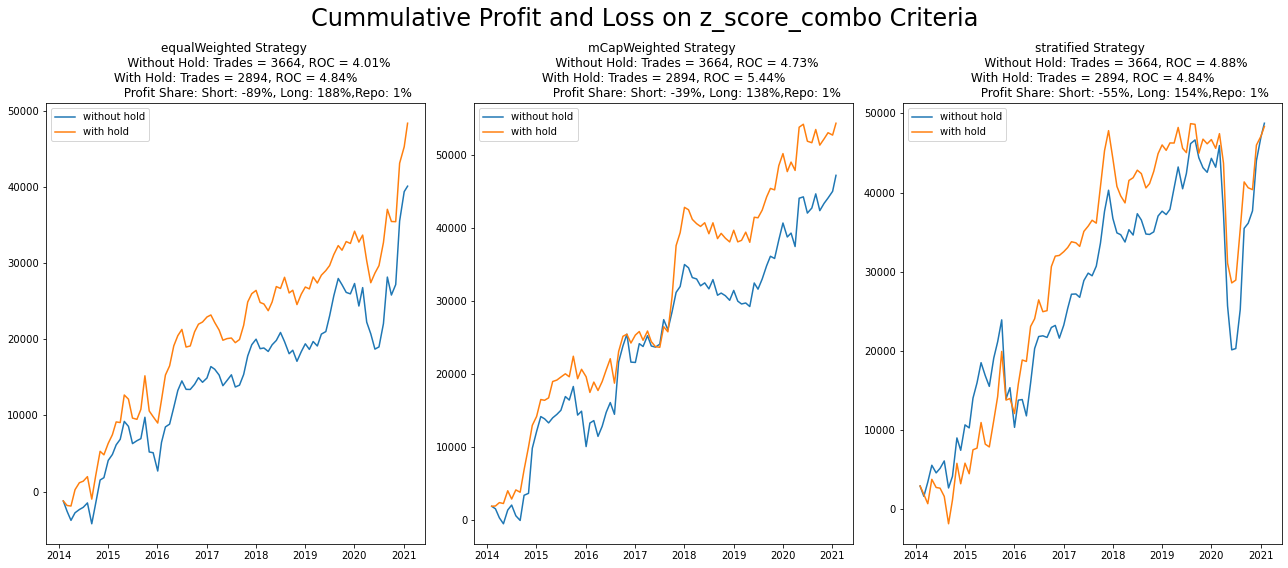

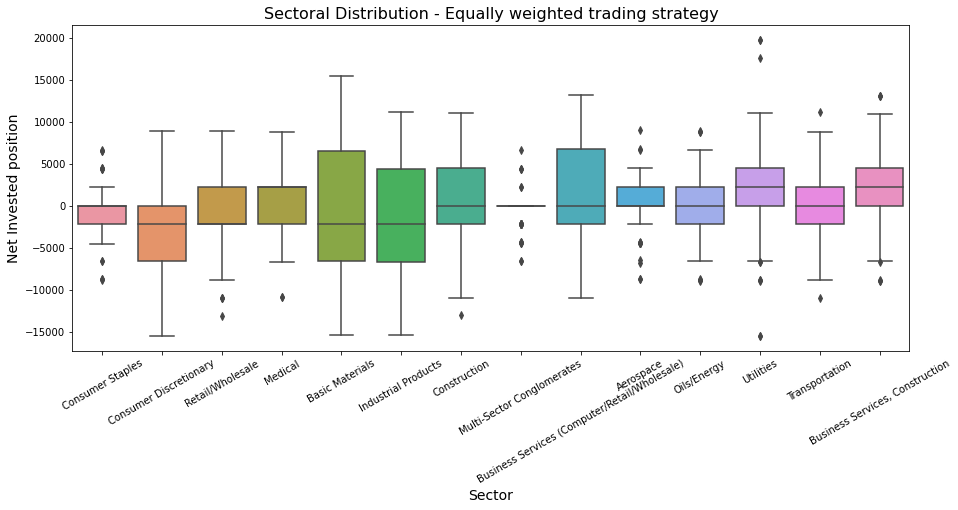

,Mean Annualized Return,Annualized Volatility,Sharpe Ratio,Skewness,Excess Kurtosis,Minimum return
Strategy,,,,,,
equalWeighted,"5,662.85","6,925.70",0.82,0.58,2.70,"-4,560.12"
mCapWeighted,"6,673.52","7,145.92",0.93,0.48,1.65,"-4,846.19"
stratified,"6,883.48","11,018.83",0.62,-1.07,3.98,"-11,633.68"


In [34]:
strategy2 = analyzeStrategy(initialCapital = 1000000,rankCriteria ='z_score_combo',quantile = 0.1,holdingWindow =0.2)

<b> Observations: Combo z-score strategy</b> <br>
<u> Cummulative Profit and Loss </u>
1. This time, the equal weighted strategy underperforms both MarketCap weighted and stratified weighted strategies.
2. <b> In each of the strategy, the short positions loses money over the time horizon. </b> The losses are much bigger than the ones we saw in the prvious strategy, especailly for the equally weighted strategy. 
3. Stratified strategy had large year to year variations in the performance. This is also visible in the larger annualized volatility for this strategy.
4. The strategies that implement a hold on the stocks in a trading window performed much better than the other strategies here. 
<br>
<br>
<u> Sector weights </u>
1. The straty distributes weights across most of the industry sectors over time.
2. There are large long short positions in traditional sectors of Basic Materials and Industrial Products<br>
<br>
<u> Performance Summary Statistics </u>
1. The returns are again extremely volatile. This is because the series is constructed using month on month performances and returns in each month typically vary quite a lot
2. Owing to the large volatility figures, the sharpe ratios are not as good

### f. Strategy III: Neutral Performing Strategy: z_debt_to_earnings	
This strategy is based on our composite factor made using two fundamental factors. We note that this strategy's performance is in between its consitutent's performances

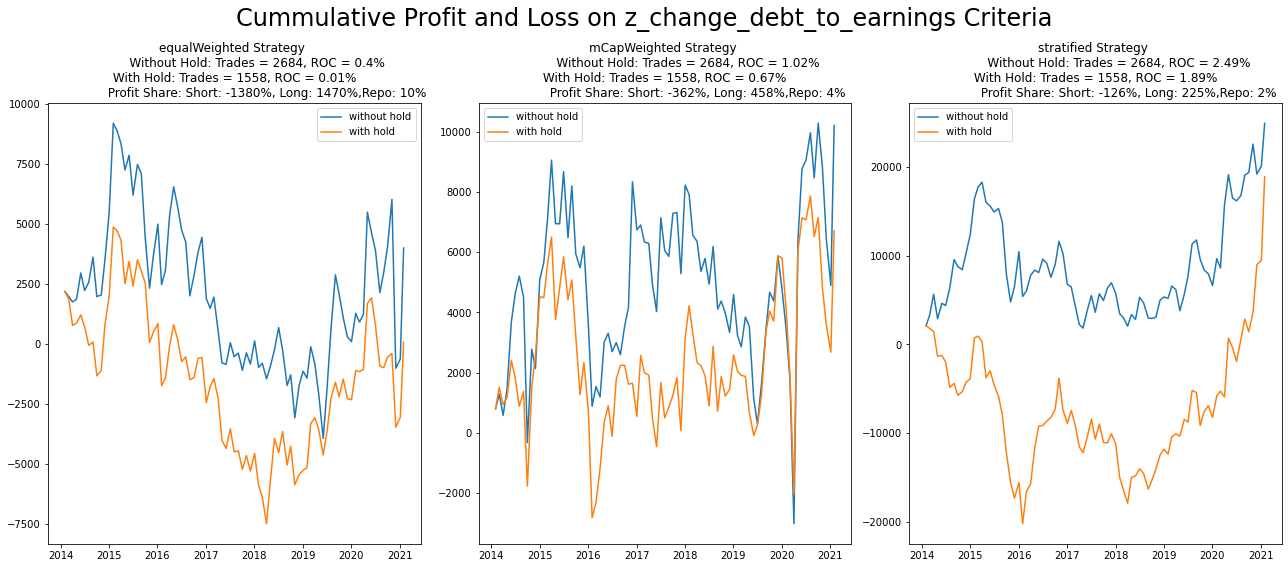

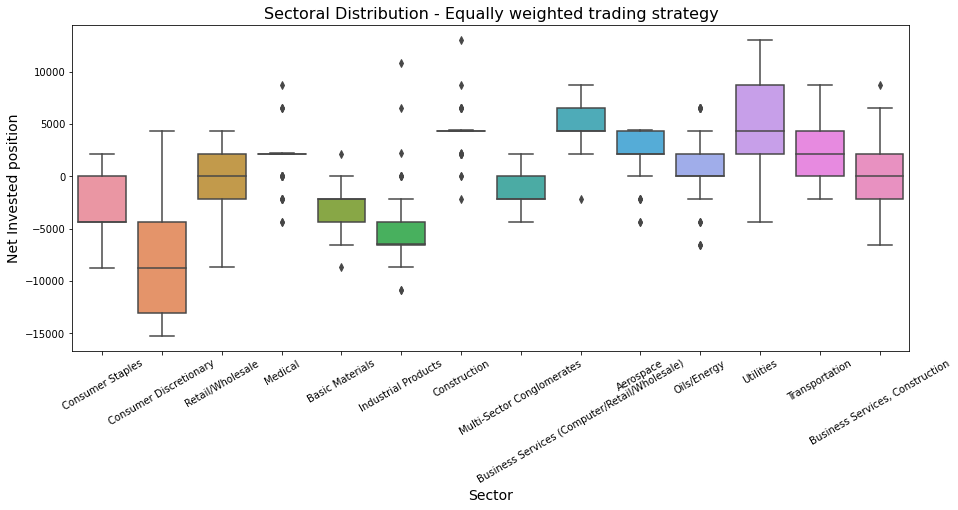

,Mean Annualized Return,Annualized Volatility,Sharpe Ratio,Skewness,Excess Kurtosis,Minimum return
Strategy,,,,,,
equalWeighted,563.91,"5,677.73",0.10,-0.47,3.78,"-7,028.61"
mCapWeighted,"1,442.91","7,015.79",0.21,1.11,4.86,"-4,833.83"
stratified,"3,514.52","7,559.78",0.46,0.02,0.65,"-5,778.93"


In [35]:
strategy3 = analyzeStrategy(initialCapital = 1000000,rankCriteria = 'z_change_debt_to_earnings',\
                            quantile = 0.1,holdingWindow = 0.2)

<b> Observations: Debt to Earnings Ratio z-score strategy</b> <br>
<u> Cummulative Profit and Loss </u>
1. Again we do not have a vast difference between strategies that implement Hold and strategies that do not implement Hold
2. The neutral returns could be attributed entirely to the losses incurred on the short positions
<br>
<br>
<u> Sector weights </u>
1. We note that the sector weights are skewed with large short positions in Retail/Wholesale and long positions in Conglomorates and Utilities. Thus more unbalanced strategy tended to perform worse than sector neutral strategy.
<br>
<u> Performance Summary Statistics </u>
1. We again observe very high volatility in returns

### g. Strategy IV: Poorly Performing Strategy: z_debt_to_earnings	
Again we analyze the strategy using different weighing schemes

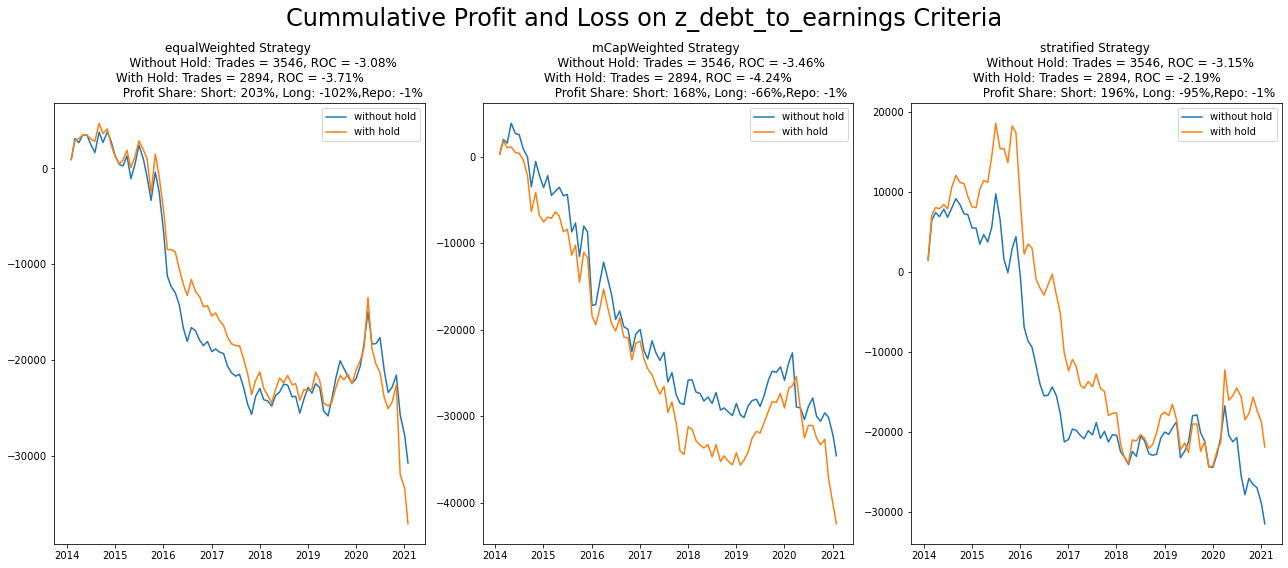

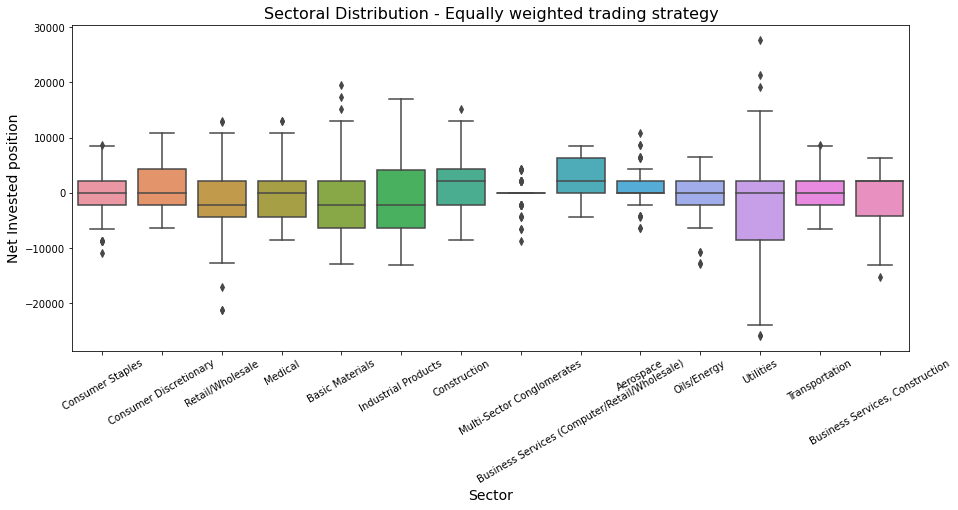

,Mean Annualized Return,Annualized Volatility,Sharpe Ratio,Skewness,Excess Kurtosis,Minimum return
Strategy,,,,,,
equalWeighted,"-4,343.68","5,675.71",-0.77,-0.22,-0.00,"-4,551.79"
mCapWeighted,"-4,879.48","6,850.53",-0.71,-1.03,2.81,"-8,499.00"
stratified,"-4,443.61","7,277.05",-0.61,-0.24,0.49,"-6,240.46"


In [36]:
strategy4 = analyzeStrategy(initialCapital = 1000000,rankCriteria ='z_debt_to_earnings',quantile=0.1,holdingWindow =0.2)

<b> Observations: Debt to Earnings Ratio z-score strategy</b> <br>
<u> Cummulative Profit and Loss </u>
1. The equal-weighted strategy underperforms the least as compared with MarketCap weighted and stratified weighted strategies.
2. <b> In each of the strategy, the short positions loses a lot more money over the time horizon. The long position is unable to make up for these losses </b> Thus the bull run over the 7 year time period does not capture the debt to earnings relationship we have computed. 
3. The strategies performed poorly almost over the entire time period.
4. The strategies that implement a hold on the stocks in a trading window performed equally badly as compared to the stratagies without such hold conditions. 
<br>
<br>
<u> Sector weights </u>
1. The strategies distributes weights across most of the industry sectors over time.
2. The portfolio goes short on utilites and construction while going long on consumer discretionries<br>
<br>
<u> Performance Summary Statistics </u>
1. The returns are again extremely volatile. This is because the series is constructed using month on month performances and returns in each month typically vary quite a lot

### h. Overall Observations
Based on the various strategies considered, we make the following observations:
1. Introducing a Holding window for stocks does not affect the raw performance of the strategy while reduces the number of trades substantially. <b> Thus it is an excellent idea to have a holding window while executing Quantile trading. </b>
2. We do not observe any substantial performance improvement from increasing the trading quantiles. Thus a narrow quantile around 10% is adequate to explot the pricing differences.
3. Equal Weighted strategy (1/N) generally performs as good or better than other weighing schemes. This also in general has the lowest variance. Thus it may be prudent to keep the strategy simple by weighing all the components equally weighted. 
4. Strategies that were more sector neutral performed better
5. Strategy based on Debt-to-Market cap z-score emerged as the best strategy though this may not always hold true

<b> Scope for improvement:</b>
- <b> We note that most strategies gave very good returns on the Long positions while losing a lot of money on short positions. This is because of the general bull market trends witnessed in the market over the last decade. </b>
- Thus a better strategy could involve taking unequal long and short positions with larger allocation to lon positions. Such strategies would be less volatile though would have higher correlation to market returns.
- Another aspect to explore could be trying a smaller set of stocks to go short as shorting requires substantial costs. We could do a more fundamental analysis of such stocks and choose only a limited number of them.

## 5. Comparison with Fama-French style (Long-Short) factors

As Quantile Trading strategy implemented here is a Long-Short market neutral strategy, its returns may be compared with the returns on other Long-Short factors. We use the Fama-French factors for this purpose.

In [37]:
#Import and create level series of the Fama-French factors
ff_rtn = pdr.DataReader("F-F_Research_Data_Factors_daily","famafrench",'2013-12-02')[0]/100
ffLevels = (ff_rtn+1).cumprod()

In [38]:
#Construct long-short returns
longShortReturns = pd.DataFrame(columns=['ExitDate','Mkt-RF','SMB','HML','RF'])
longShortReturns.index.name = 'index'
for i in tracker.index:
    s,e = tracker.loc[i]['EnterDate'], tracker.loc[i]['ExitDate']
    a,b,c,d = (ffLevels.loc[e]/ffLevels.loc[s] - 1)
    longShortReturns.loc[i] = [e,a,b,c,d]

longShortReturns['QuantileStrategy'] = strategy1[0].EndCapital/strategy1[0].EndCapital.shift() - 1
longShortReturns = longShortReturns.dropna()
longShortReturns['QuantileStrategy'] = longShortReturns['QuantileStrategy'].astype(float)

longShortReturns = longShortReturns.set_index('ExitDate')
longShortReturns.index.name = 'Date'

### a. Correlation of Best Performing Quantile Strategy with Fama-French factors

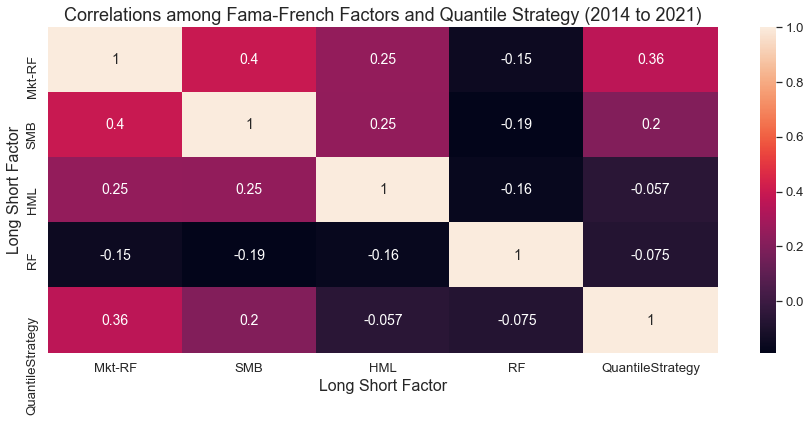

In [42]:
p =sns.heatmap(longShortReturns.corr(),annot = True,annot_kws={"fontsize":14})
p.set_xlabel("Long Short Factor", fontsize = 16)
p.set_ylabel("Long Short Factor", fontsize = 16)
p.set_title('Correlations among Fama-French Factors and Quantile Strategy (2014 to 2021)', fontsize = 18)
plt.show()

<b> Observations: </b> The Quantile Strategy has a relatively high correlation of 0.36 with the Mkt-RF factor. This indicates that this Long Short strategy is not entirely market neutral. We investigate this further over a period of time.

### b. Correlations over yearly time period 
We now evaluate the correlation of our Quantile Trading Strategy with Fama-French style factor over each of the year from 2014 to 2020.

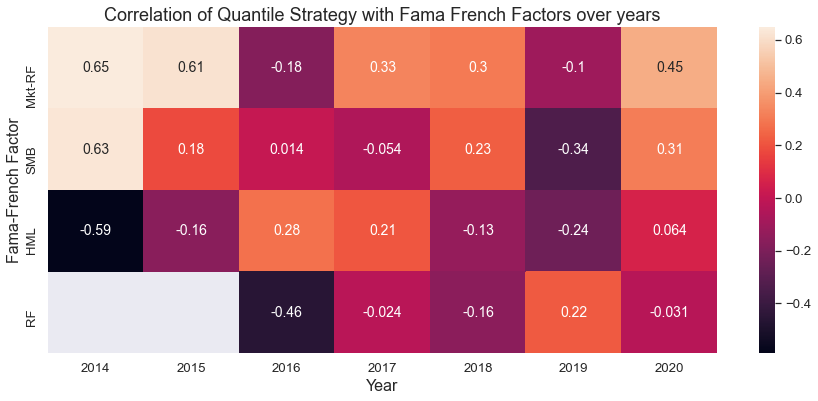

In [40]:
QuantileCorr = pd.DataFrame(index = ['Mkt-RF','SMB','HML','RF'])
for y in range(2014,2021):
     QuantileCorr[y] = longShortReturns.loc[str(y)].corr()['QuantileStrategy']

sns.set(font_scale = 1.2)
p = sns.heatmap(QuantileCorr,annot=True,annot_kws={"fontsize":14})  
p.set_xlabel("Year", fontsize = 16)
p.set_ylabel("Fama-French Factor", fontsize = 16)
p.set_title('Correlation of Quantile Strategy with Fama French Factors over years', fontsize = 18)
plt.show()

<b> Observations :</b>
1. We observe a relatively high correlation of our trading stratey with Mkt-RF factor in 5 out 7 years. <b> Thus our strategy does not do a good job in diversyfying the market risks. This is also because our strategy consistently oes long on the best performing financial ratios which could include some of the companies in the market portfolio. </b>
2. The strategy has fairly low correlation with other Fama-French style factors especially HML. Thus such a strategy could be used in addition to Fama-French style investing to get additional alpha.
3. There is a high correlation to SMB factor in the year 2020. This was a volatile market year ad the advent of Covid-19 crisis. We could expect higher correlations among all factors during this year.

## 6. Conclusions
- We demonstrated the construction of “quantamental” model from vast financial data and isolated various financial ratios on which we could rank our strategies. 
- We constructed nine z-score parameters which could be used to rank our strategy
- We executed a simple equally weighted monthly quantile trading strategies on each of these z-scores 
- We analyzed four strategies in greater detail and observed the dynamics of changing quantiles, holding window and weighting schemes. The conclusions and best practices were outlined in section 4.
- We compared our best performing trading strategy to Fama-French style factors.